In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
import csv
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)
import numpy as np
import importlib
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import CleanData, SaveState
importlib.reload(CleanData)
importlib.reload(SaveState)
from CleanData import clean_comment, get_bag_of_words

[nltk_data] Downloading package stopwords to /home/zchao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Get stopword list
stop_words = stopwords.words('english')
number_strs = ['one', 'two', 'three', 'four', 'five', 'six', 'seven',\
'eight', 'nine', 'ten']
stop_words.extend(number_strs)

In [3]:
# Load tweet from members
tweets_df = pd.read_csv('news_filtered.csv')

In [4]:
# TheIJR = Independent Journal Review; AP = Associated Press; NPR = National Public Radio; NRO = National Review
# TPM = Talking Points Memo
mediaList = [['thinkprogress', -20], ['MSNBC', -20],['thenation',-17],['thedailybeast',-16],['CNN',-15],
       ['MotherJones',-15],['cnsnews',26],['foxnewsradio',24],['FDRLST',23],['BreitbartNews',20],
       ['DailyCaller',20],['theblaze',16],['FoxNews',15],['BBC',-2],['businessinsider',-1],['CBSNews',-2],
       ['TheEconomist',-3], ['thehill',0],['WSJ',2],['ABC',-1],['AP',-1],['TheAtlantic',-7],['axios',-6],
       ['BBC',-3],['BuzzFeed',-8],['DailySignal',25],['newrepublic',-12],['ForeignPolicy',-2],['TheIJR',7],
       ['NRO',15],['NPR',-3],['nypost',4],['nytimes',-4],['NewYorker',-8],['newsmax',13],['Newsweek',-3],
       ['OANN',14],['politico',-5],['qz',-4],['reason',3],['Reuters',-1],['Slate',-19],['TPM',-6],
       ['VanityFair',-18],['voxdotcom',-10],['dcexaminer',12],['FreeBeacon',18],['washingtonpost',-4],
       ['WashTimes',13],['TheWeek',-9]]

media_bias_df = pd.DataFrame(mediaList, columns =['MediaTwitterAcc', 'LeftRightCoordinate'])

all_media = media_bias_df['MediaTwitterAcc'].tolist()
left_media = media_bias_df.loc[media_bias_df['LeftRightCoordinate']<=-15]
left_media = left_media['MediaTwitterAcc'].tolist()
right_media = media_bias_df.loc[media_bias_df['LeftRightCoordinate']>=15]
right_media = right_media['MediaTwitterAcc'].tolist()
neutral_media = media_bias_df.loc[(media_bias_df['LeftRightCoordinate']>=-6) \
                                & (media_bias_df['LeftRightCoordinate']<=6)]
neutral_media = neutral_media['MediaTwitterAcc'].tolist()
extreme_media = left_media+right_media
len(left_media), len(right_media), len(neutral_media)

(8, 10, 21)

In [5]:
tweets_df = tweets_df.loc[tweets_df['user_name'].isin(all_media)]
tweets_df = tweets_df.head(100000)

In [6]:
# Random take 5 left_media and 5 right_media as training set.
import random
k = 5
# random.shuffle(left_media)
# train_left_media = left_media[:k]
# test_left_media = left_media[k:]
# random.shuffle(right_media)
# train_right_media = right_media[:k]
# test_right_media = right_media[k:]

random.shuffle(left_media)
train_extreme_media = extreme_media[:k]
test_extreme_media = extreme_media[k:]
random.shuffle(neutral_media)
train_neutral_media = neutral_media[:k]
test_neutral_media = neutral_media[k:]

print(train_extreme_media, train_neutral_media)

['thinkprogress', 'MSNBC', 'thenation', 'thedailybeast', 'CNN'] ['ABC', 'qz', 'NPR', 'TheEconomist', 'nytimes']


In [19]:
import preprocessor as p
tweets_df['clean_tweet']  = tweets_df['clean_tweet'].apply(p.clean)
bag_of_words, vectorizer = get_bag_of_words(tweets_df['clean_tweet'],ngram_range=(1,3), min_df=0.0005)

In [20]:
print(vectorizer.get_feature_names())

['000', '000 people', '10', '100', '11', '13', '130', '130 000', '15', '18', '20', '200', '30', '300', '50', '500', 'abc', 'ability', 'able', 'abolish', 'abortion', 'abroad', 'absolutely', 'abuse', 'abuse allegations', 'abuses', 'academy', 'accept', 'access', 'accident', 'accidentally', 'according', 'according new', 'account', 'accounts', 'accusations', 'accused', 'accusers', 'accuses', 'across', 'across country', 'act', 'acting', 'action', 'actions', 'active', 'activist', 'activists', 'activity', 'actor', 'actress', 'acts', 'actual', 'actually', 'ad', 'adam', 'adam schiff', 'add', 'added', 'addiction', 'adding', 'additional', 'address', 'addresses', 'adds', 'admin', 'administration', 'admits', 'admitted', 'ads', 'adult', 'adults', 'advance', 'advantage', 'advice', 'adviser', 'advisers', 'advocates', 'affair', 'affairs', 'affect', 'affected', 'affordable', 'afghan', 'afghanistan', 'africa', 'african', 'african american', 'ag', 'age', 'agencies', 'agency', 'agenda', 'agent', 'agent atta

In [8]:
# Train binary multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics
def get_binary_NB_model(bag_of_words, df):
    # Training data:
#     class1_words = bag_of_words[df['user_name'].isin(train_left_media),:]
#     class2_words = bag_of_words[df['user_name'].isin(train_right_media),:]
    class1_words = bag_of_words[df['user_name'].isin(train_neutral_media),:]
    class2_words = bag_of_words[df['user_name'].isin(train_extreme_media),:]
    train_tweets = np.concatenate((class1_words,class2_words))
    labels = np.concatenate((np.zeros(class1_words.shape[0]),np.ones(class2_words.shape[0])))
    nb = ComplementNB()
    nb.fit(train_tweets, labels)
    # # Performance on training data
    predictions = nb.predict(train_tweets)
    print('Training Accuracy: ' + str(sum(labels==predictions)/len(labels)))
    # Compute the error.
    tn, fp, fn, tp = metrics.confusion_matrix(labels,predictions).ravel()
    print(tn, fp, fn, tp)
    return nb

In [9]:
nb_model = get_binary_NB_model(bag_of_words, tweets_df)

Training Accuracy: 0.6851242143070937
10213 3775 3589 5810


In [13]:
# predictions = nb_model.predict(bag_of_words[tweets_df['user_name'].isin(test_users),:])
# tweets_df['nb_tweet_pred'] = np.NaN
# tweets_df.loc[tweets_df['user_name'].isin(test_users),['nb_tweet_pred']] = predictions
predict_probs = nb_model.predict_proba(bag_of_words)
tweets_df['neutral_prob'] = predict_probs[:,0]
tweets_df['extreme_prob'] = predict_probs[:,1]
tweets_df['nb_tweet_pred'] = nb_model.predict(bag_of_words)

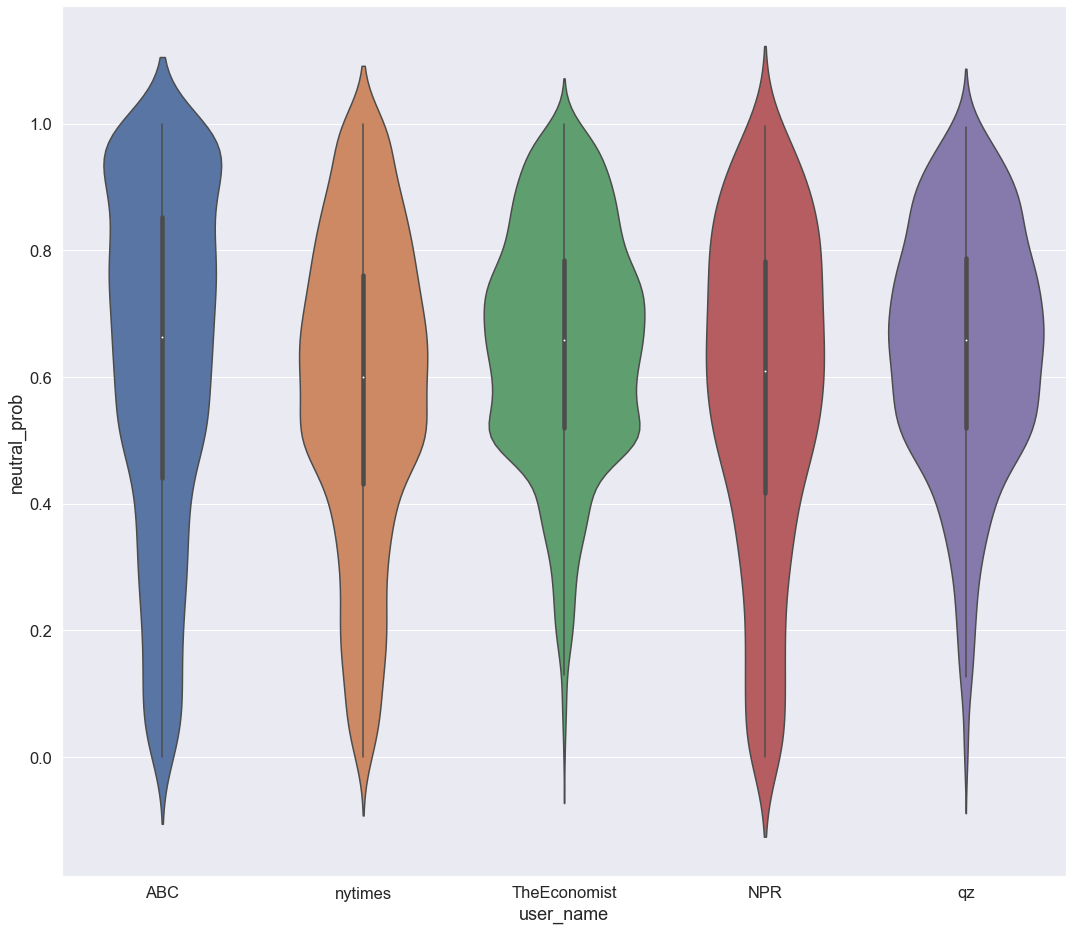

In [14]:
# Make scatter plots for train_neutral_media:
plt.figure(figsize=(18, 16))
sns.violinplot(x='user_name', y='neutral_prob', data=tweets_df.loc[tweets_df['user_name'].isin(train_neutral_media)])

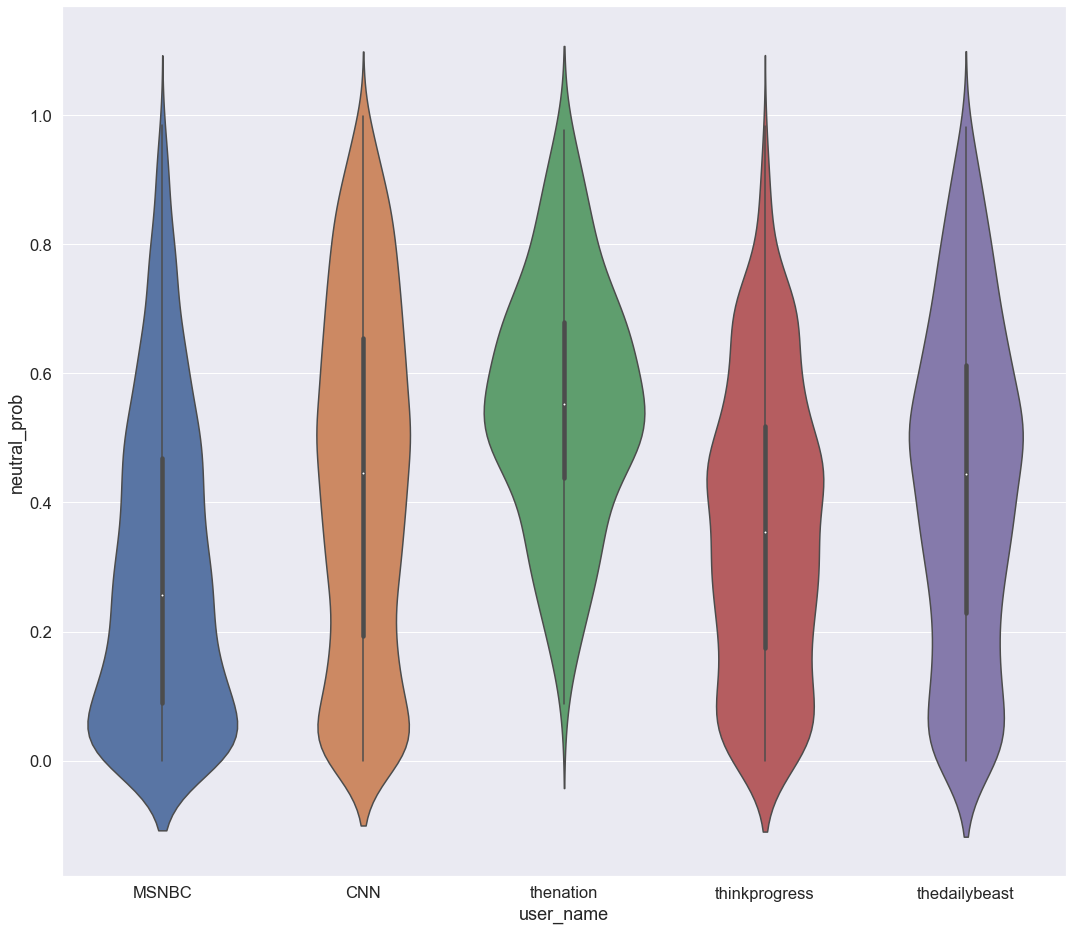

In [15]:
# Make scatter plots for train_extreme_media:
plt.figure(figsize=(18, 16))
sns.violinplot(x='user_name', y='neutral_prob', data=tweets_df.loc[tweets_df['user_name'].isin(train_extreme_media)])

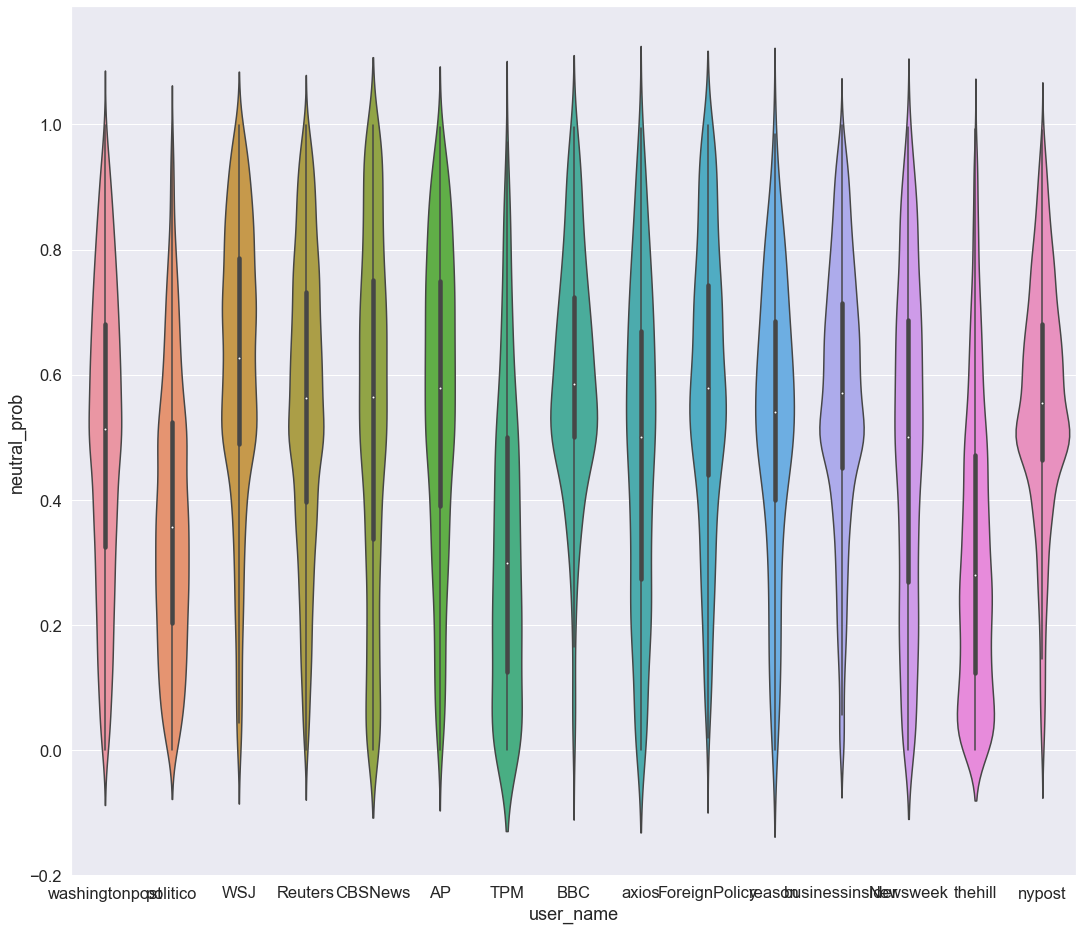

In [16]:
# Make scatter plots for test_neutral:
plt.figure(figsize=(18, 16))
sns.violinplot(x='user_name', y='neutral_prob', data=tweets_df.loc[tweets_df['user_name'].isin(test_neutral_media)])

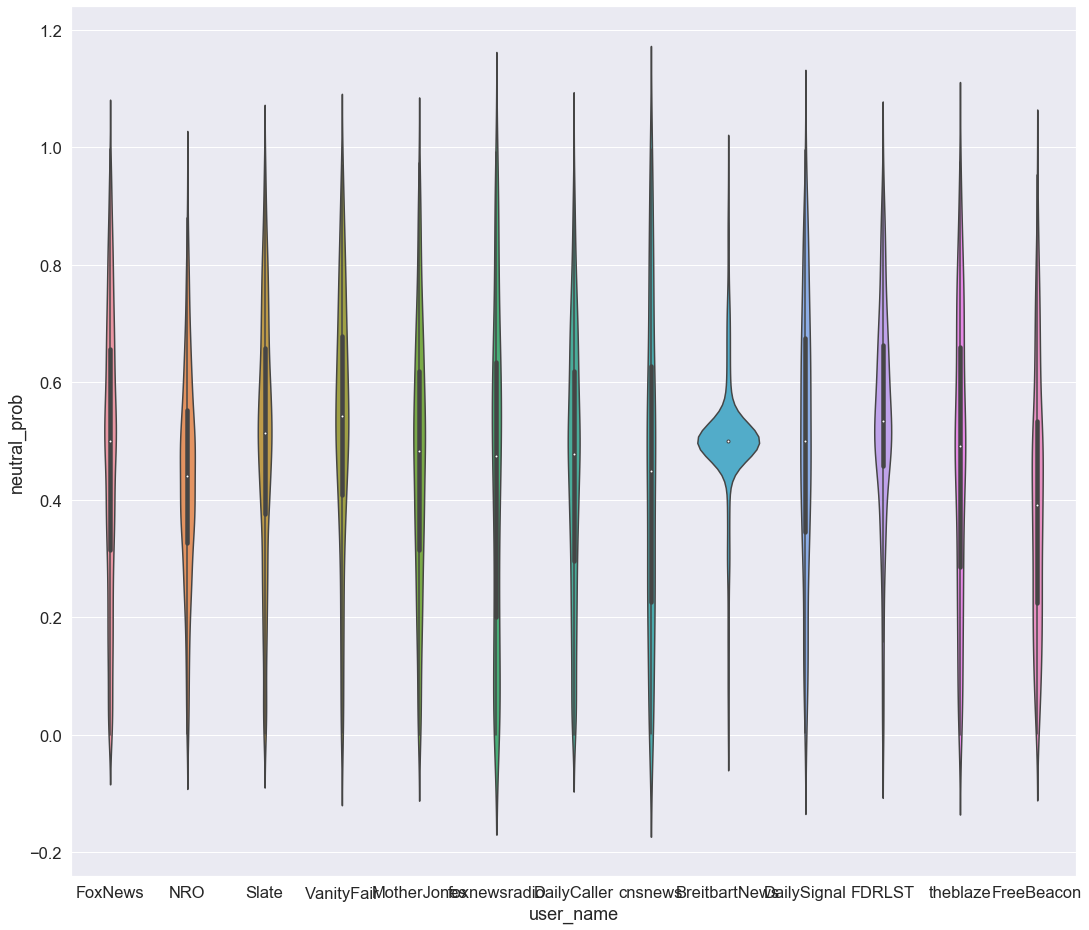

In [17]:
# Make scatter plots for test_extreme:
plt.figure(figsize=(18, 16))
sns.violinplot(x='user_name', y='neutral_prob', data=tweets_df.loc[tweets_df['user_name'].isin(test_extreme_media)])

In [ ]:
# # Make scatter plots for test_right:
# plt.figure(figsize=(18, 16))
# sns.violinplot(x='user_name', y='neutral_prob', data=tweets_df.loc[tweets_df['user_name'].isin(neutral_media)])

In [ ]:
bag_of_words